Useful sources:
- https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver
- https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html
- https://arxiv.org/pdf/2305.01480v1

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

For MIS (from arxiv paper)

$ H = \sum_{j \in V} h_j x_j + \sum_{(j,k)\in E}J_{j,k}x_j x_k $

$ h_j = 1 $; and $J_{j,k} = 2$ if $(j,k) \in E$, $0$ otherwise

In [2]:
# consider graph with 4 nodes
# and edges AB, AC, BC, BD, CD
# the MIS is {A, D}

# works, ~5.5 seconds for 1000 evals
# nodes = 4
# edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
# should get 1001 order ABCD

# works, 
nodes = 6
edges = [(0, 2), (1, 3), (2, 3), (3, 4), (3, 5)]
# should get 011011 or 110011 order ABCDEF

h = np.ones(nodes)
J = np.zeros((nodes, nodes))
for j, k in edges:
    J[j][k] = 2
    J[k][j] = 2
print(J)

# each qubit is Z in pauli basis, I guess
sparse_list = []
for j, h_j in enumerate(h):
    sparse_list.append(("Z", [j], h_j))
for j, J_j in enumerate(J):
    for k, J_jk in enumerate(J_j):
        if J_jk != 0:
            sparse_list.append(("ZZ", [j, k], J_jk))
hamiltonian = SparsePauliOp.from_sparse_list(sparse_list, num_qubits=nodes)

[[0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [2. 0. 0. 2. 0. 0.]
 [0. 2. 2. 0. 2. 2.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 0. 0.]]


In [3]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
num_params = ansatz.num_parameters
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz.layout)

In [4]:
from qiskit_aer.primitives import Estimator as AerEstimator, Sampler as AerSampler
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(int(i), int(i)+1) for i in range(0, nodes-1)]
device = GenericBackendV2(num_qubits=nodes, coupling_map=coupling_map, seed=1995)
noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": 1995, "shots": 1024},
    transpile_options={"seed_transpiler": 1995},
)

noisy_sampler = AerSampler(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": 1995, "shots": 1024},
    transpile_options={"seed_transpiler": 1995},
)

In [5]:
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import SamplingVQE, VQE

iterations = []
def callback(*args):
    print("iteration", args[0])
    print("evaluated mean", args[2])
    iterations.append(args)
    
def callback_sample(*args):
    # print("iteration", args[0], "\t", "evaluated mean", args[2])
    iterations.append(args)

spsa = SPSA(maxiter=1000)
# vqe = VQE(noisy_estimator, ansatz, optimizer=spsa, callback=callback)
vqe = SamplingVQE(noisy_sampler, ansatz, optimizer=spsa, callback=callback_sample)
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)

In [6]:
from qiskit.result import QuasiDistribution
def print_result(result):
    # selection = result.x
    # value = result.fval
    # print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = 0
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))
print_result(result)


----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 1 1]	0.0000		0.9463
[0 0 1 0 1 1]	0.0000		0.0098
[1 0 1 0 1 1]	0.0000		0.0059
[0 1 1 0 0 1]	0.0000		0.0049
[1 1 1 0 1 1]	0.0000		0.0049
[1 1 0 0 1 1]	0.0000		0.0049
[1 0 0 1 1 1]	0.0000		0.0049
[0 1 1 1 1 1]	0.0000		0.0049
[1 0 0 0 1 1]	0.0000		0.0020
[0 1 1 0 1 0]	0.0000		0.0020
[0 0 1 1 1 1]	0.0000		0.0020
[1 1 0 0 0 0]	0.0000		0.0020
[1 0 0 1 0 0]	0.0000		0.0020
[1 0 0 1 0 1]	0.0000		0.0010
[0 1 0 1 0 1]	0.0000		0.0010
[0 1 0 0 1 1]	0.0000		0.0010
[1 1 0 0 0 1]	0.0000		0.0010


Text(0.5, 1.0, 'Convergence with noise')

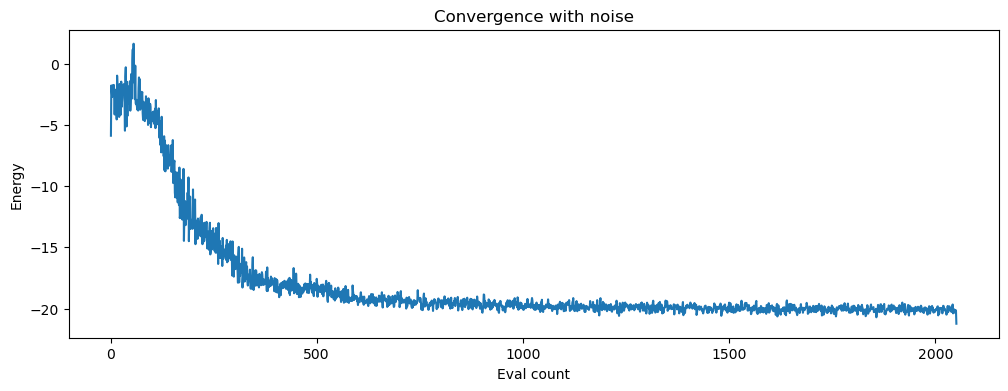

In [7]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
counts = [i[0] for i in iterations]
values = [i[2].real for i in iterations]
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with noise")

Text(0.5, 1.0, 'Relative error with noise')

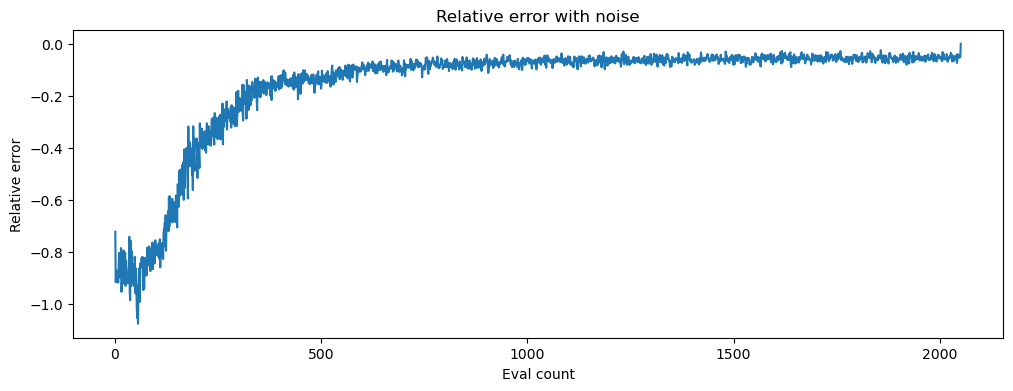

In [8]:
_actual_value = result.optimal_value.real

pylab.rcParams["figure.figsize"] = (12, 4)
counts = [i[0] for i in iterations]
rel_errors = [(i[2].real - _actual_value) / _actual_value for i in iterations]
pylab.plot(counts, rel_errors)
pylab.xlabel("Eval count")
pylab.ylabel("Relative error")
pylab.title("Relative error with noise")

In [19]:
# https://github.com/qiskit-community/qiskit-algorithms/pull/184
# pip install --force-reinstall -v "scipy<1.14"
# pip install --force-reinstall -v "numpy<2.0.0"
# :P

from qiskit_algorithms import NumPyEigensolver
from numpy import log10

result_cl = NumPyEigensolver().compute_eigenvalues(operator=hamiltonian)
print(result_cl.eigenvalues)

[-22.]


In [28]:
ref_value = result_cl.eigenvalues[0]
print("numpy value", ref_value)
print("VQE value", _actual_value)

accuracy = -1 * log10(abs(ref_value - _actual_value))
print("accuracy", accuracy)

numpy value -21.999999999999996
VQE value -21.232421875
accuracy 0.11487741060040606


In [29]:
total_time = sum(i[3]['simulator_metadata']['time_taken'] for i in iterations)
total_time

21.814286832999986